## Import needed libraries

In [119]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Read image from file and display in gray

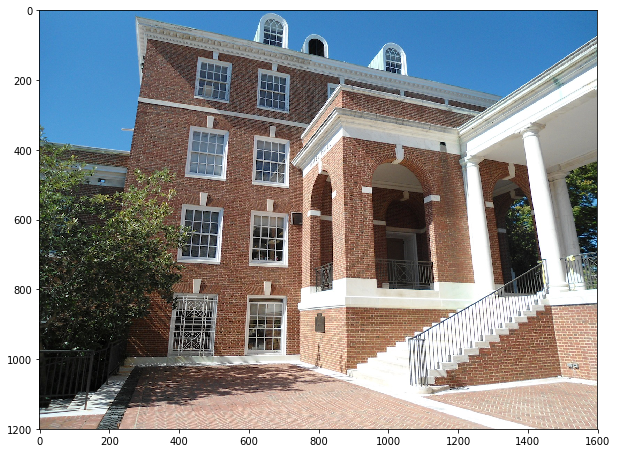

In [125]:
image = plt.imread('../ames1.JPG')
plt.figure(figsize=(10,20))
plt.imshow(image)

# a)

## Define filters, convolution and plot the result

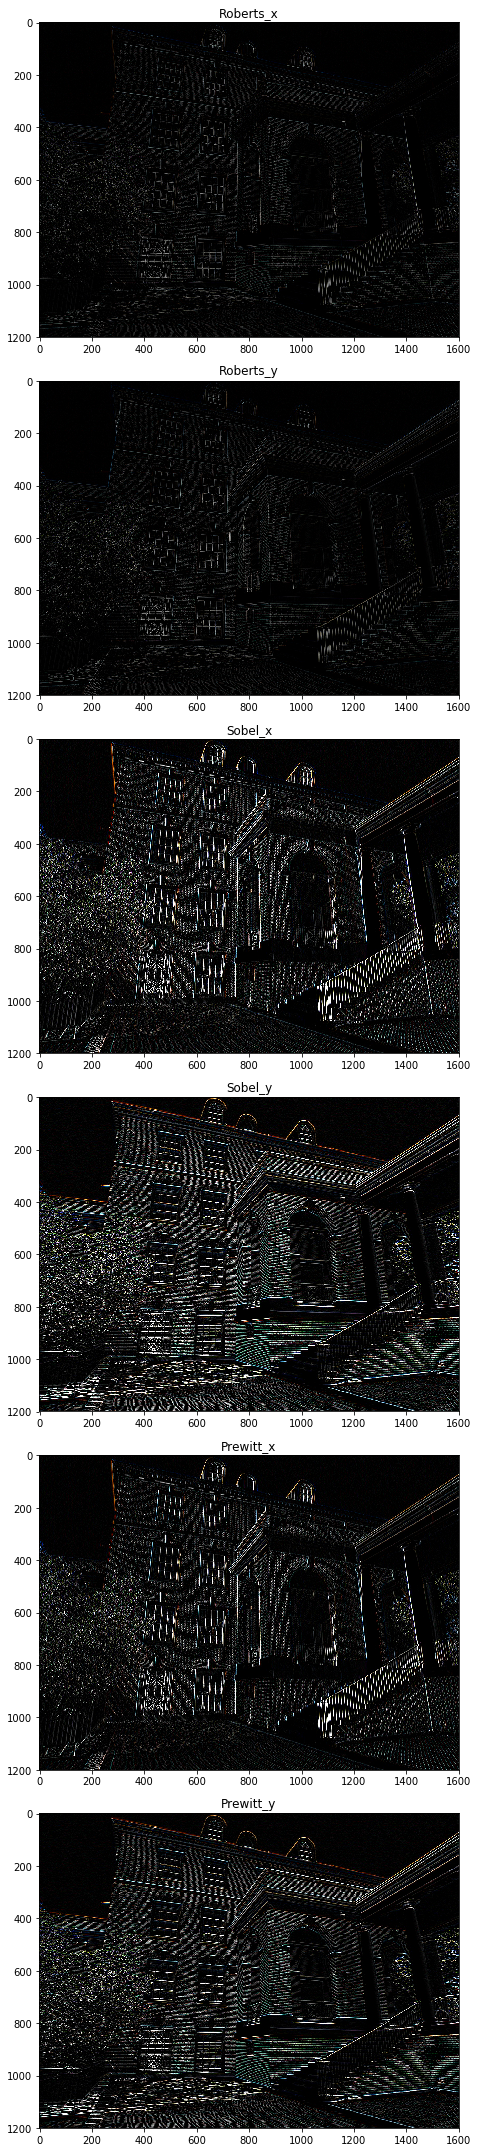

In [126]:
# Roberts edge operator
kernel_Roberts_x = np.array([
    [0, 1],
    [-1, 0]])
kernel_Roberts_y = np.array([
    [1, 0],
    [0, -1]])

# Sobel edge operator
kernel_Sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]])
kernel_Sobel_y = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]])

# Prewitt edge operator
kernel_Prewitt_x = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]])
kernel_Prewitt_y = np.array([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]])

outputs = []

outputs.append(cv2.filter2D(image, -1, kernel_Roberts_x))
outputs.append(cv2.filter2D(image, -1, kernel_Roberts_y))
outputs.append(cv2.filter2D(image, -1, kernel_Sobel_x))
outputs.append(cv2.filter2D(image, -1, kernel_Sobel_y))
outputs.append(cv2.filter2D(image, -1, kernel_Prewitt_x))
outputs.append(cv2.filter2D(image, -1, kernel_Prewitt_y))

rows = 6
cols = 1
axes=[]
fig = plt.figure(figsize=(10,30))
titles = ["Roberts_x", "Roberts_y", "Sobel_x", "Sobel_y", "Prewitt_x", "Prewitt_y"]

for i in range(rows):
    axes.append(fig.add_subplot(rows, cols, i+1) )
    axes[-1].set_title(titles[i])  
    plt.imshow(outputs[i])
    
fig.tight_layout()    
plt.show()

# b)

## Noise reduction

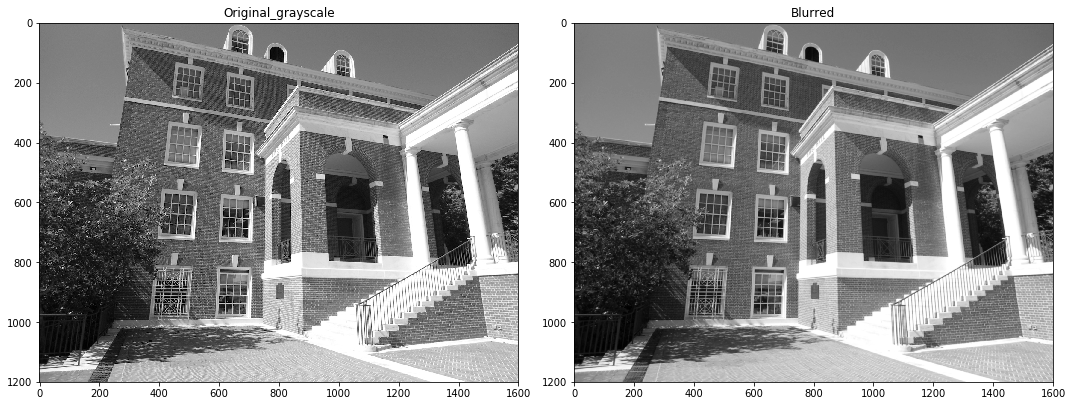

In [127]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

rows = 1
cols = 2
axes=[]
fig = plt.figure(figsize=(15,10))

image_grayscale = rgb2gray(image)
axes.append(fig.add_subplot(rows, cols, 1) )
axes[-1].set_title("Original_grayscale")  
plt.imshow(image_grayscale, cmap="gray")

axes.append(fig.add_subplot(rows, cols, 2) )
axes[-1].set_title("Blurred")  
image_blurred = cv2.filter2D(image_grayscale, -1, gaussian_kernel(5))
plt.imshow(image_blurred, cmap="gray")
    
fig.tight_layout()    
plt.show()

## Gradient calculation

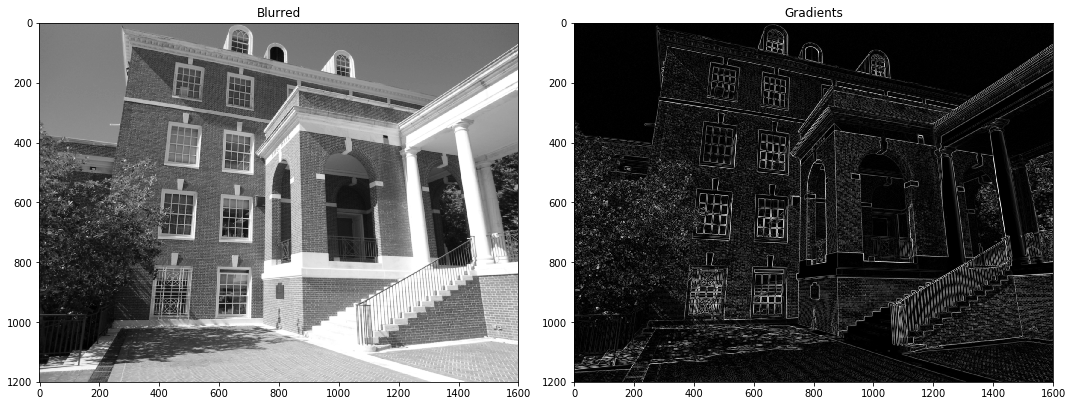

In [141]:
def sobel_filters(image):    
    Ix = cv2.filter2D(image, -1, kernel_Sobel_x)
    Iy = cv2.filter2D(image, -1, kernel_Sobel_y)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

axes=[]
fig = plt.figure(figsize=(15,10))

axes.append(fig.add_subplot(rows, cols, 1) )
axes[-1].set_title("Blurred")  
plt.imshow(image_blurred, cmap="gray")

G, theta = sobel_filters(image_blurred)
axes.append(fig.add_subplot(rows, cols, 2) )
axes[-1].set_title("Gradients")  
plt.imshow(G, cmap="gray")
    
fig.tight_layout()    
plt.show()

## Non-Maximum Suppression

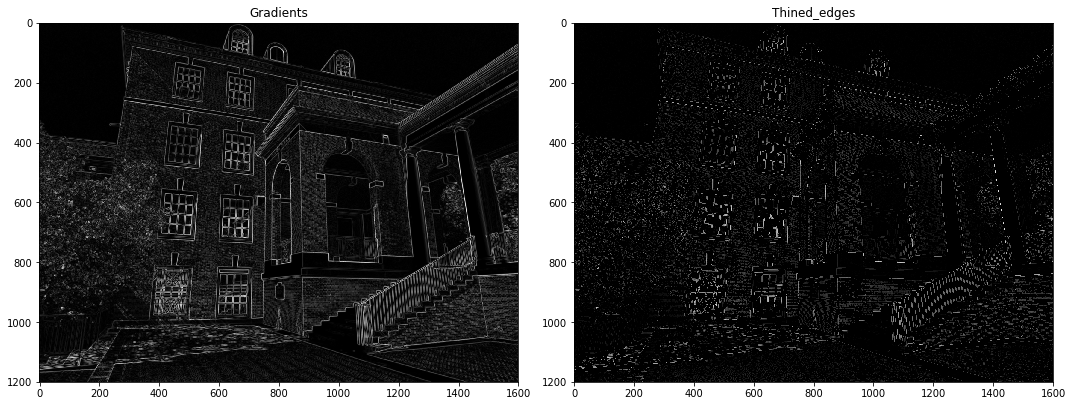

In [143]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

axes=[]
fig = plt.figure(figsize=(15,10))

axes.append(fig.add_subplot(rows, cols, 1) )
axes[-1].set_title("Gradients")  
plt.imshow(G, cmap="gray")

image_thined_edges = non_max_suppression(G, theta)
axes.append(fig.add_subplot(rows, cols, 2) )
axes[-1].set_title("Thined_edges")  
plt.imshow(image_thined_edges, cmap="gray")
    
fig.tight_layout()    
plt.show()

## Double threshold

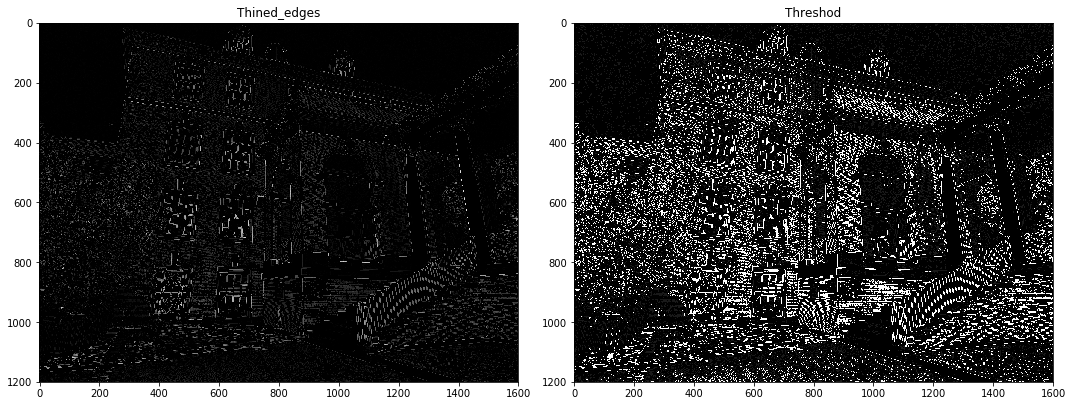

In [145]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

axes=[]
fig = plt.figure(figsize=(15,10))

axes.append(fig.add_subplot(rows, cols, 1))
axes[-1].set_title("Thined_edges")  
plt.imshow(image_thined_edges, cmap="gray")

image_thresholded = threshold(image_thined_edges)[0]
axes.append(fig.add_subplot(rows, cols, 2))
axes[-1].set_title("Threshod")  
plt.imshow(image_thresholded, cmap="gray")

fig.tight_layout()    
plt.show()

## Edge Tracking by Hysteresis

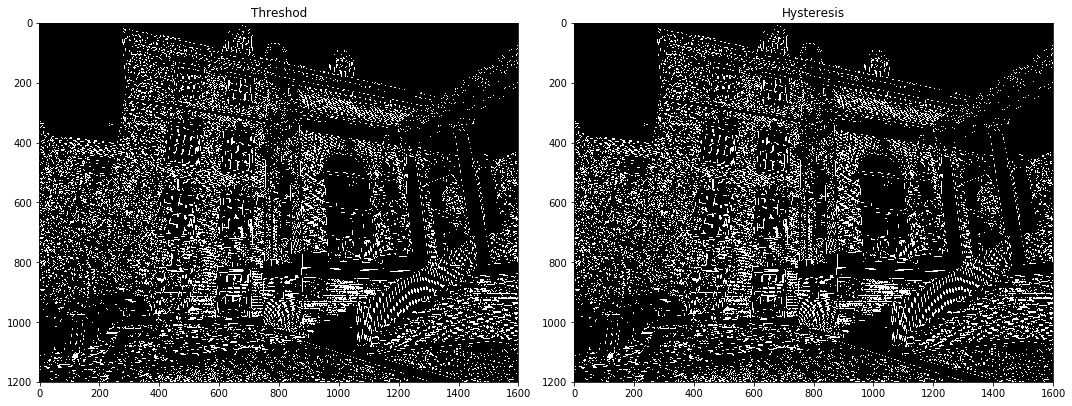

In [147]:
def hysteresis(img, weak=25, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

axes=[]
fig = plt.figure(figsize=(15,10))

axes.append(fig.add_subplot(rows, cols, 1))
axes[-1].set_title("Threshod")  
plt.imshow(image_thresholded, cmap="gray")

image_hysteresis = hysteresis(image_thresholded)
axes.append(fig.add_subplot(rows, cols, 2))
axes[-1].set_title("Hysteresis")  
plt.imshow(image_hysteresis, cmap="gray")

fig.tight_layout()    
plt.show()